In [9]:
# === Imports ===
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
sns.set_palette("pastel")
os.makedirs("../images", exist_ok=True)

def savefig(name):
    plt.savefig(f"../images/{name}.png", dpi=150, bbox_inches="tight")

In [10]:
import pandas as pd
from pathlib import Path

data_path = Path("../data/online_retail.xlsx")
assert data_path.exists(), f"File not found: {data_path}. Put the Excel here."

# Inspect available sheets (Online Retail II typically has two: 'Year 2009-2010' and 'Year 2010-2011')
xls = pd.ExcelFile(data_path)
print("Available sheets:", xls.sheet_names)

dfs = [pd.read_excel(data_path, sheet_name=s) for s in xls.sheet_names]
df = pd.concat(dfs, ignore_index=True)

print("Shape after load:", df.shape)
display(df.head())


Available sheets: ['Year 2009-2010', 'Year 2010-2011']
Shape after load: (1067371, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [11]:
# === Load dataset (Excel) ===
import pandas as pd
from pathlib import Path

data_path = Path("../data/online_retail.xlsx")
assert data_path.exists(), f"File not found: {data_path}. Put your Excel file in /data folder."

# Load all sheets if there are two ('Year 2009-2010', 'Year 2010-2011')
xls = pd.ExcelFile(data_path)
print("Available sheets:", xls.sheet_names)

# Combine all sheets into one DataFrame
dfs = [pd.read_excel(data_path, sheet_name=s) for s in xls.sheet_names]
df = pd.concat(dfs, ignore_index=True)

print("Shape after load:", df.shape)
display(df.head())

Available sheets: ['Year 2009-2010', 'Year 2010-2011']
Shape after load: (1067371, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [3]:
# === Resolve column names (robust) ===
# Normalize headers: remove spaces/underscores, keep case-insensitive matching easy
df.columns = df.columns.str.strip().str.replace(" ", "").str.replace("_", "")

print("Normalized columns:", list(df.columns))

def pick_first_col(candidates):
    """Return the first candidate that exists in df.columns, else None."""
    for c in candidates:
        if c in df.columns:
            return c
    return None

# Common variants across Online Retail / Online Retail II
INVOICE_NO_COL   = pick_first_col(["InvoiceNo","Invoice","Invoicenumber"])
DATE_COL         = pick_first_col(["InvoiceDate","Date"])
CUSTOMER_ID_COL  = pick_first_col(["CustomerID","CustomerId","Customer","CustomerCode","CustID"])
QTY_COL          = pick_first_col(["Quantity","Qty","QTY"])
PRICE_COL        = pick_first_col(["UnitPrice","Price","Unitcost","UnitAmount","UnitPriceGBP"])

required = {
    "INVOICE_NO_COL": INVOICE_NO_COL,
    "DATE_COL": DATE_COL,
    "CUSTOMER_ID_COL": CUSTOMER_ID_COL,
    "QTY_COL": QTY_COL,
    "PRICE_COL": PRICE_COL,
}
missing = [k for k,v in required.items() if v is None]
print("Resolved mapping:", required)
assert not missing, f"Missing required columns: {missing}. Check df.columns printed above and adjust candidates."

Normalized columns: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'CustomerID', 'Country']
Resolved mapping: {'INVOICE_NO_COL': 'Invoice', 'DATE_COL': 'InvoiceDate', 'CUSTOMER_ID_COL': 'CustomerID', 'QTY_COL': 'Quantity', 'PRICE_COL': 'Price'}


In [4]:
# === Clean data for RFM ===
import numpy as np
import pandas as pd

# Drop duplicates
df = df.drop_duplicates()

# Remove rows without customer id
df = df.dropna(subset=[CUSTOMER_ID_COL])

# Coerce numeric columns
df[QTY_COL]   = pd.to_numeric(df[QTY_COL], errors="coerce")
df[PRICE_COL] = pd.to_numeric(df[PRICE_COL], errors="coerce")

# Keep positive quantities and prices
df = df[(df[QTY_COL] > 0) & (df[PRICE_COL] > 0)]

# Parse dates
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
df = df.dropna(subset=[DATE_COL])

# Compute line total
df["TotalPrice"] = df[QTY_COL] * df[PRICE_COL]

print("Shape after cleaning:", df.shape)
df.head()

Shape after cleaning: (779425, 9)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [5]:
# === Build RFM table ===
latest_date = df[DATE_COL].max() + pd.Timedelta(days=1)

rfm = (
    df.groupby(CUSTOMER_ID_COL)
      .agg(
          Recency   = (DATE_COL,   lambda x: (latest_date - x.max()).days),
          Frequency = (INVOICE_NO_COL, "nunique"),   # unique invoices per customer
          Monetary  = ("TotalPrice", "sum")
      )
      .reset_index()
)

rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,12,77556.46
1,12347.0,2,8,4921.53
2,12348.0,75,5,2019.40
3,12349.0,19,4,4428.69
4,12350.0,310,1,334.40


In [6]:
# === RFM Scoring (quartiles with safe fallbacks) ===

def qcut_safe(series, q=4, labels=None, invert=False):
    s = series.copy()
    # Rank to help qcut when many duplicates
    r = s.rank(method="first", na_option="keep")
    try:
        out = pd.qcut(r, q, labels=labels)
    except Exception:
        # Fallback to equal-width on ranks
        out = pd.cut(r, q, labels=labels, include_lowest=True)
    if invert:
        # reverse labels order (e.g., for Recency: lowest days -> highest score)
        if labels is not None:
            rev_map = {labels[i]: labels[::-1][i] for i in range(len(labels))}
            out = out.map(rev_map)
    return out

labels_4 = [1,2,3,4]  # ascending

# Recency: lower is better -> invert to make low recency get high score
rfm["R_Score"] = qcut_safe(rfm["Recency"],  q=4, labels=labels_4, invert=True)
# Frequency/Monetary: higher is better
rfm["F_Score"] = qcut_safe(rfm["Frequency"], q=4, labels=labels_4, invert=False)
rfm["M_Score"] = qcut_safe(rfm["Monetary"],  q=4, labels=labels_4, invert=False)

rfm["R_Score"] = rfm["R_Score"].astype(int)
rfm["F_Score"] = rfm["F_Score"].astype(int)
rfm["M_Score"] = rfm["M_Score"].astype(int)

# Combined string score like '444', '321', etc.
rfm["RFM_Score"] = rfm["R_Score"].astype(str) + rfm["F_Score"].astype(str) + rfm["M_Score"].astype(str)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,12346.0,326,12,77556.46,2,4,4,244
1,12347.0,2,8,4921.53,4,4,4,444
2,12348.0,75,5,2019.40,3,3,3,333
3,12349.0,19,4,4428.69,4,3,4,434
4,12350.0,310,1,334.40,2,1,1,211


In [7]:
# === Segment customers by RFM_Score ===
def segment_customer(row):
    r, f, m = row["R_Score"], row["F_Score"], row["M_Score"]
    total = r + f + m
    # Example rules (simple & interpretable)
    if r >= 4 and f >= 3 and m >= 3:
        return "Loyal"
    if r == 4 and f <= 2 and m <= 2:
        return "New"
    if total <= 5:
        return "Lost"
    if r <= 2 and (f >= 3 or m >= 3):
        return "At Risk"
    return "Regular"

rfm["Segment"] = rfm.apply(segment_customer, axis=1)
rfm["Segment"].value_counts()

Segment
Lost       1743
Regular    1732
At Risk    1118
Loyal      1031
New         254
Name: count, dtype: int64

,Segment,Customers
0,Lost,1743
1,Regular,1732
2,At Risk,1118
3,Loyal,1031
4,New,254


,Recency,Frequency,Monetary
Segment,,,
Loyal,11.0,17.7,9776.3
At Risk,287.4,5.6,2418.9
Regular,72.5,5.6,2297.0
New,13.6,1.8,404.4
Lost,414.1,1.3,292.5


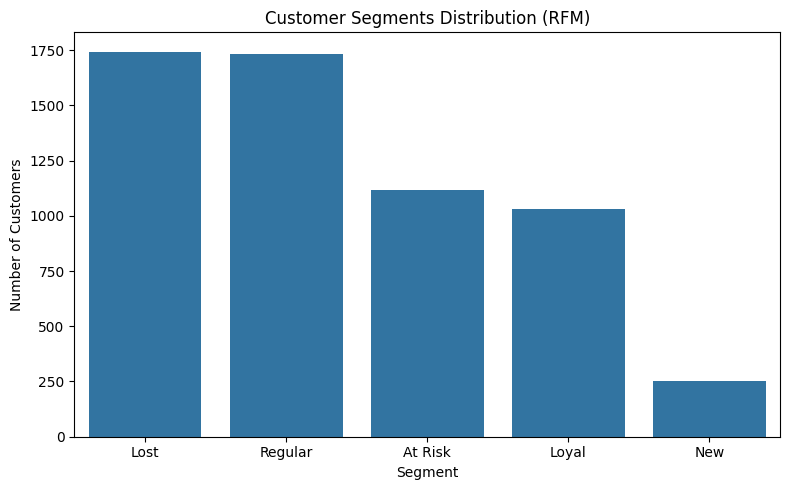

In [8]:
# === Segment summary ===
seg_summary = (
    rfm.groupby("Segment")[["Recency","Frequency","Monetary"]]
       .mean()
       .round(1)
       .sort_values("Monetary", ascending=False)
)
seg_counts = rfm["Segment"].value_counts().rename_axis("Segment").reset_index(name="Customers")

display(seg_counts)
display(seg_summary)

# === Plot distribution of segments ===
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.makedirs("../images", exist_ok=True)

plt.figure(figsize=(8,5))
order = rfm["Segment"].value_counts().index
sns.countplot(data=rfm, x="Segment", order=order)
plt.title("Customer Segments Distribution (RFM)")
plt.xlabel("Segment")
plt.ylabel("Number of Customers")
plt.tight_layout()
plt.savefig("../images/rfm_segments.png", dpi=150, bbox_inches="tight")
plt.show()

In [ ]:
# === Optional: export table with segment labels ===
out_path = "../data/rfm_customers.csv"
rfm_out = rfm[[CUSTOMER_ID_COL, "Recency", "Frequency", "Monetary", "R_Score", "F_Score", "M_Score", "RFM_Score", "Segment"]].copy()
rfm_out.to_csv(out_path, index=False)
print(f"Saved: {out_path}")